In [1]:
import sqlite3
from pathlib import Path

__file__ = %pwd
DATA = Path(__file__).parent.parent / "data"
PRIORITIES = DATA / "Priorities"
DATABASE = DATA / "databases" / "exploration.db"

import sys
sys.path.append(str(DATA.parent))  # Add the parent directory of 'modeling' to the Python path

con = sqlite3.connect(DATABASE)
cur = con.cursor()

In [2]:
import pandas as pd
import numpy as np

# Use 2021-22 data
df_2021_22 = pd.read_sql_query("SELECT * FROM ACGRWide WHERE Year = '2021-22'", con)
columns_to_drop = [col for col in df_2021_22.columns if col.startswith("UniReqs") or col.startswith("RegHSDiploma") or col.startswith("Dropout")]

# Lasso

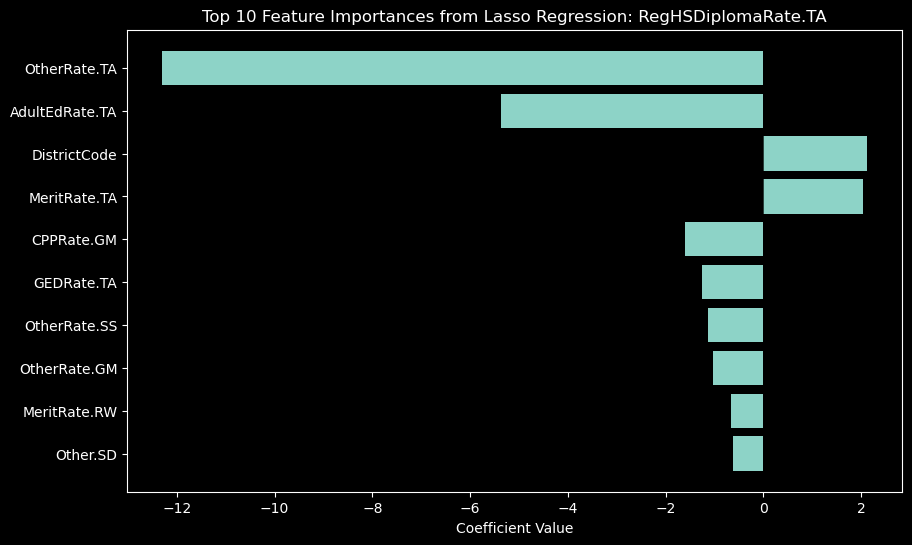

R^2 Score: -0.0001740948267947573
Mean Squared Error: 473.43169778555074
Root Mean Squared Error: 21.75848565009869


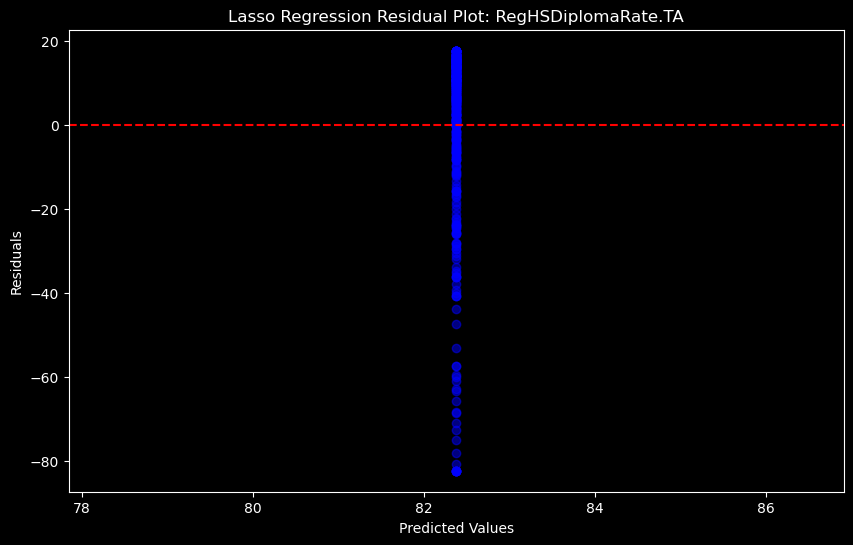

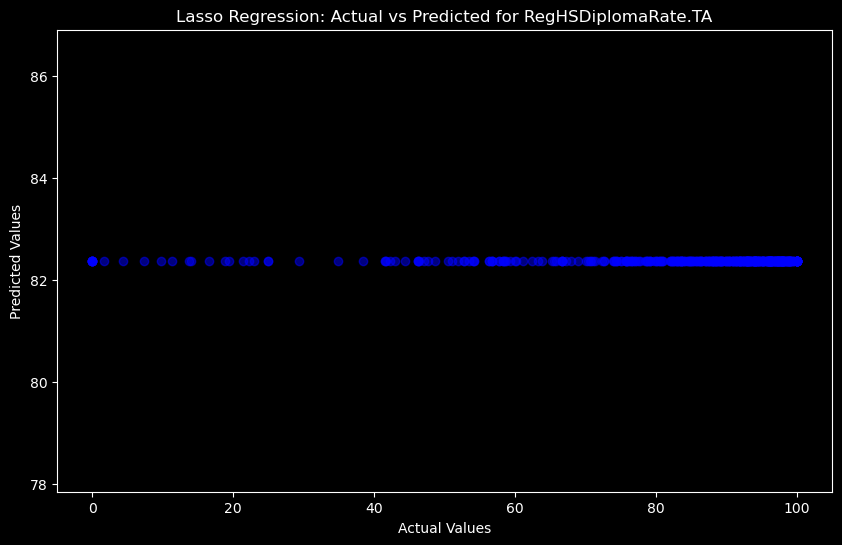

In [3]:
import modeling.utils.lasso as lasso_utils

target_column = "RegHSDiplomaRate.TA"

X_numeric, y, sorted_pairs = lasso_utils.fit_lasso_model(
    df_2021_22, target_column, columns_to_drop
)
lasso_utils.plot_lasso_coefficients(target_column, sorted_pairs)
lasso_model = lasso_utils.LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_results = lasso_utils.train_and_evaluate_lasso_model(X_numeric, y, lasso_model)
print(f"R^2 Score: {lasso_results['r2']}")
print(f"Mean Squared Error: {lasso_results['mse']}")
print(f"Root Mean Squared Error: {lasso_results['rmse']}")
lasso_utils.plot_lasso_residuals(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)
lasso_utils.plot_actual_predicted_lasso(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)

### CSU/UC Graduation Rate

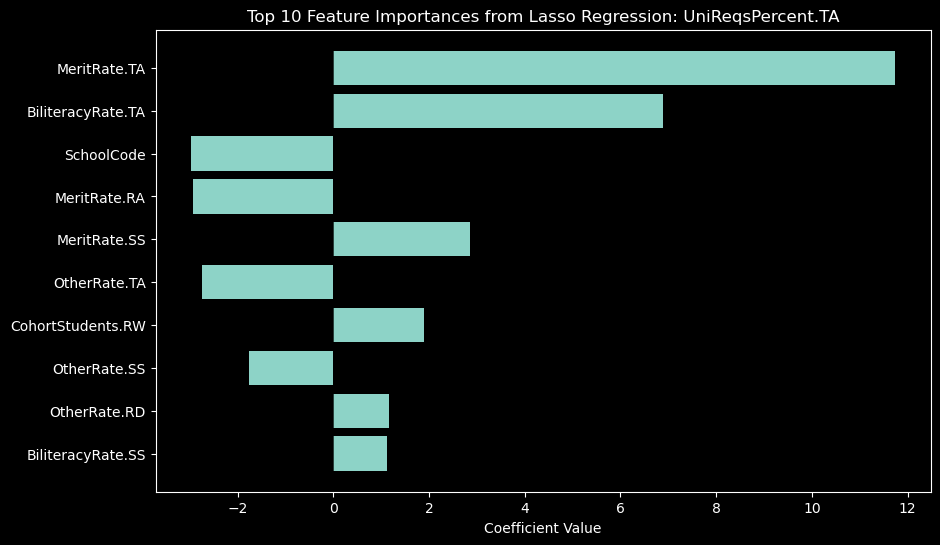

R^2 Score: -0.00017937688179570088
Mean Squared Error: 968.2405843197514
Root Mean Squared Error: 31.11656446845878


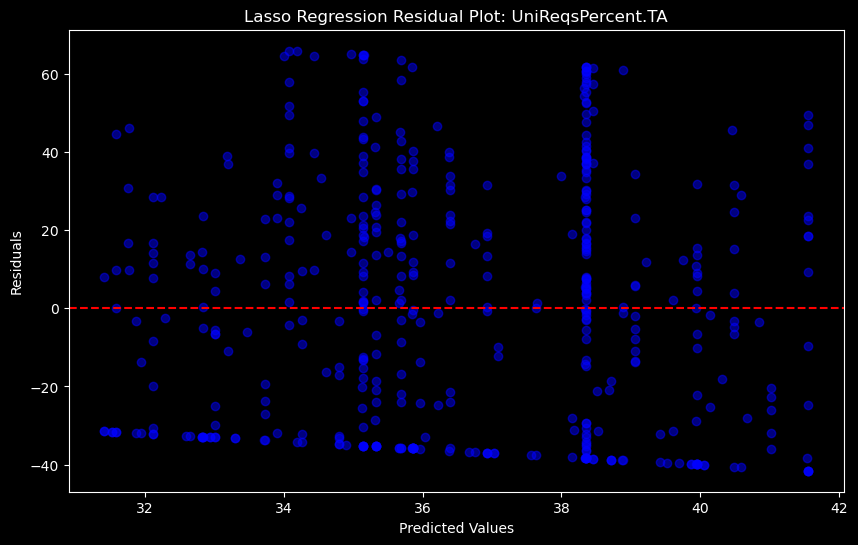

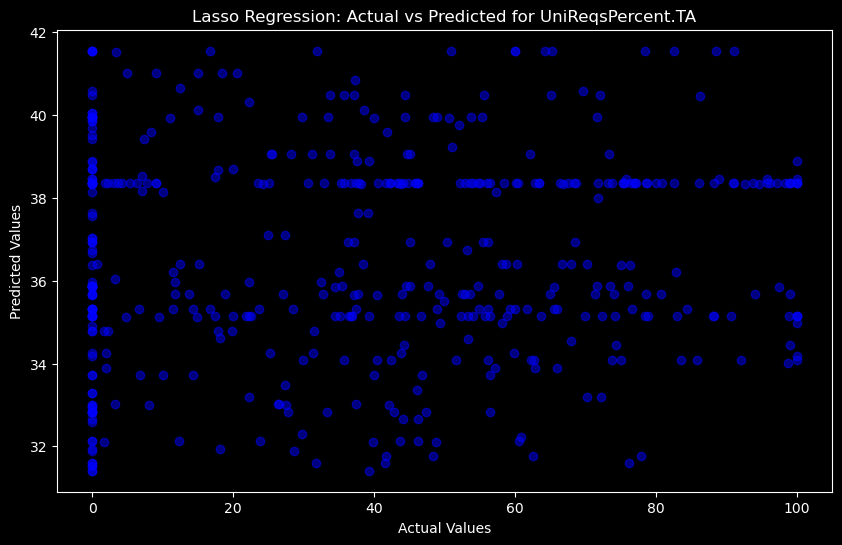

In [4]:
target_column = "UniReqsPercent.TA"


X_numeric, y, sorted_pairs = lasso_utils.fit_lasso_model(
    df_2021_22, target_column, columns_to_drop
)


lasso_utils.plot_lasso_coefficients(target_column, sorted_pairs)
lasso_model = lasso_utils.LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_results = lasso_utils.train_and_evaluate_lasso_model(X_numeric, y, lasso_model)

print(f"R^2 Score: {lasso_results['r2']}")
print(f"Mean Squared Error: {lasso_results['mse']}")
print(f"Root Mean Squared Error: {lasso_results['rmse']}")

lasso_utils.plot_lasso_residuals(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)
lasso_utils.plot_actual_predicted_lasso(
    lasso_results["y_test"], lasso_results["y_pred"], target_column
)

# XGBoost

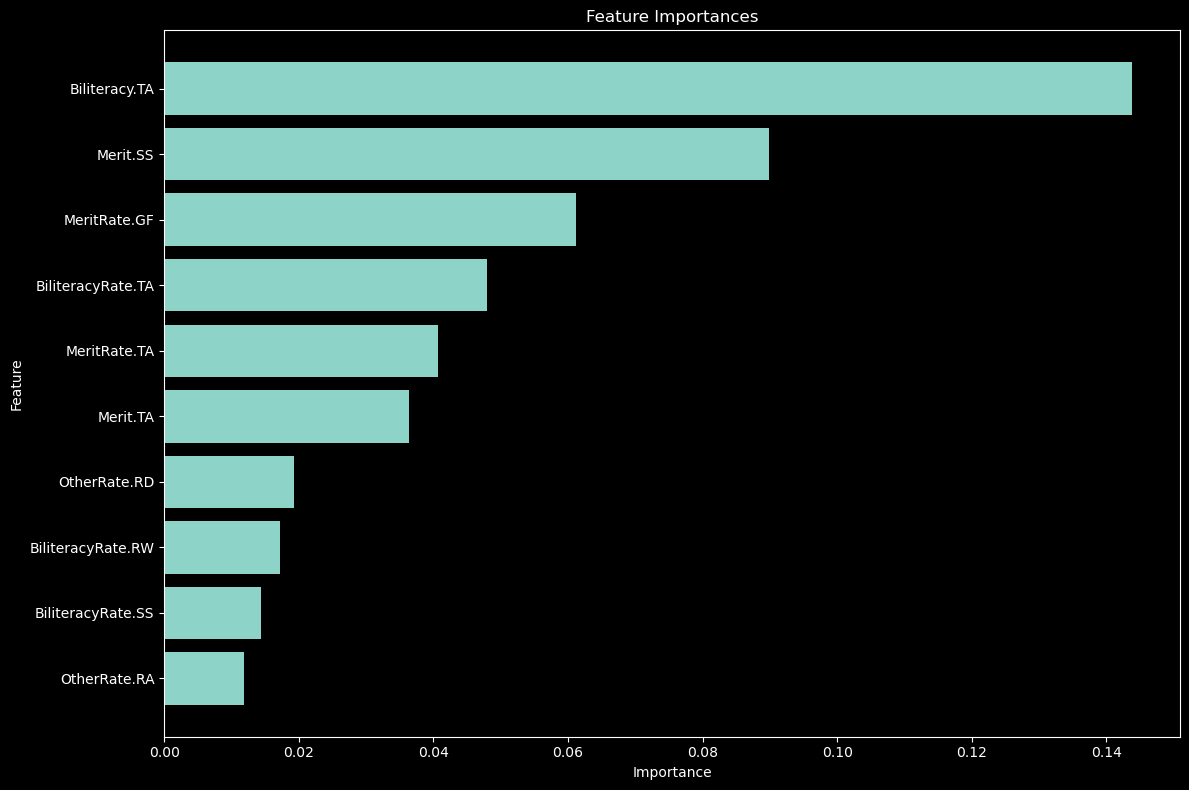

{'MSE': 249.6903500139874, 'RMSE': 15.80159327453999, 'MAE': 10.806050433710865, 'R^2': 0.7420732587181917}


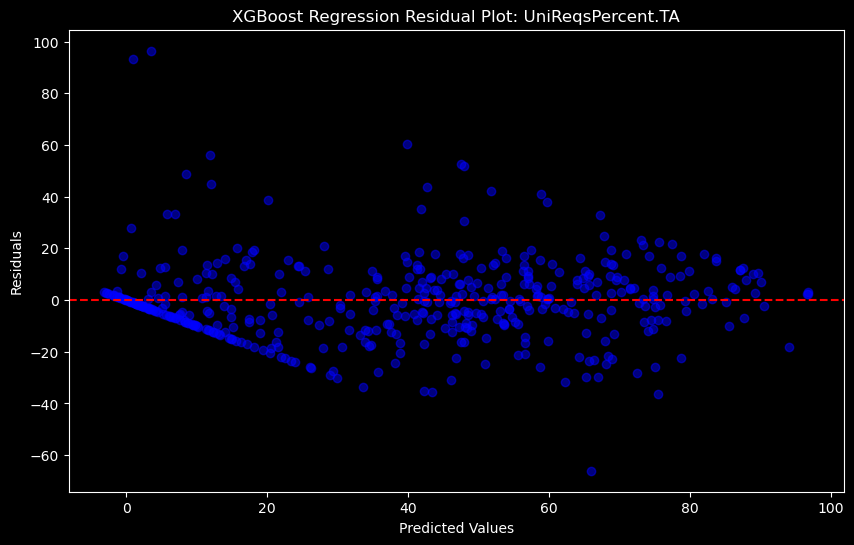

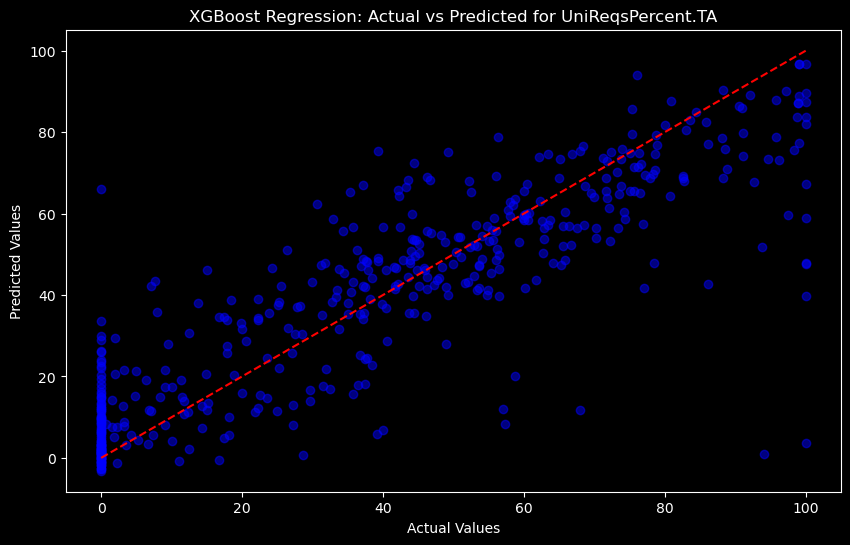

In [5]:
import modeling.utils.xgboost as xgb_utils

target_column = "UniReqsPercent.TA"
xgb_results = xgb_utils.train_xgboost_model(df_2021_22, target_column, columns_to_drop)
print(xgb_results["metrics"])
xgb_utils.plot_xgb_residuals(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)
xgb_utils.plot_xgb_predicted_actual(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)

## Graduation Rate

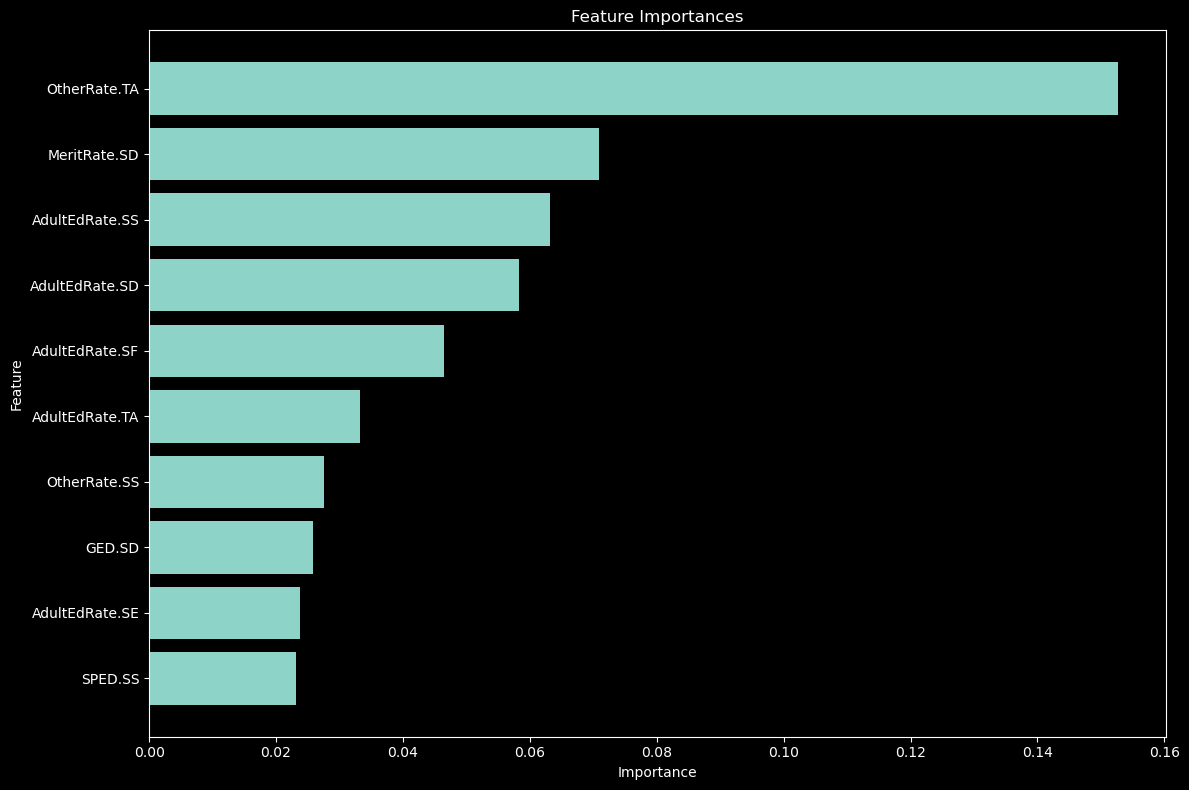

{'MSE': 87.69158428191676, 'RMSE': 9.364378478143477, 'MAE': 4.936434981797052, 'R^2': 0.814742334864063}


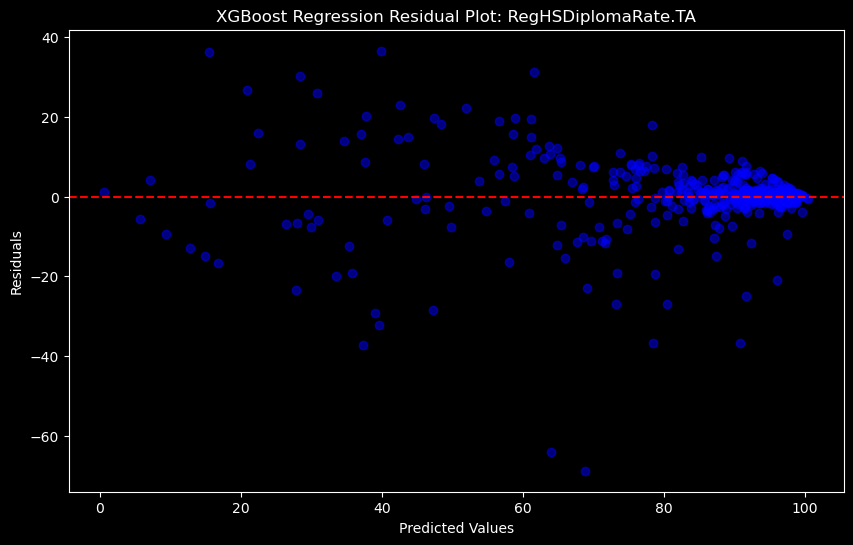

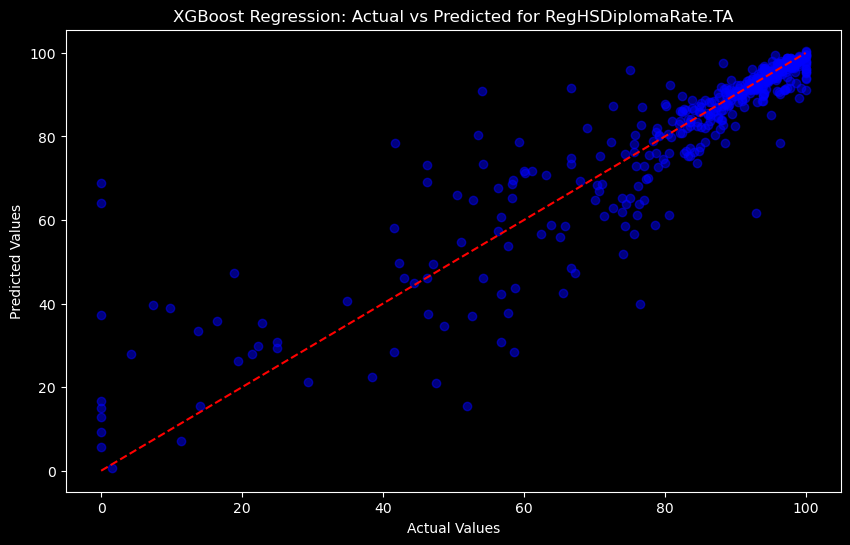

In [6]:
target_column = "RegHSDiplomaRate.TA"
xgb_results = xgb_utils.train_xgboost_model(df_2021_22, target_column, columns_to_drop)
print(xgb_results["metrics"])
xgb_utils.plot_xgb_residuals(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)
xgb_utils.plot_xgb_predicted_actual(
    xgb_results["y_test"], xgb_results["y_pred"], target_column
)

# Random Forest

Predict Graduation Rate

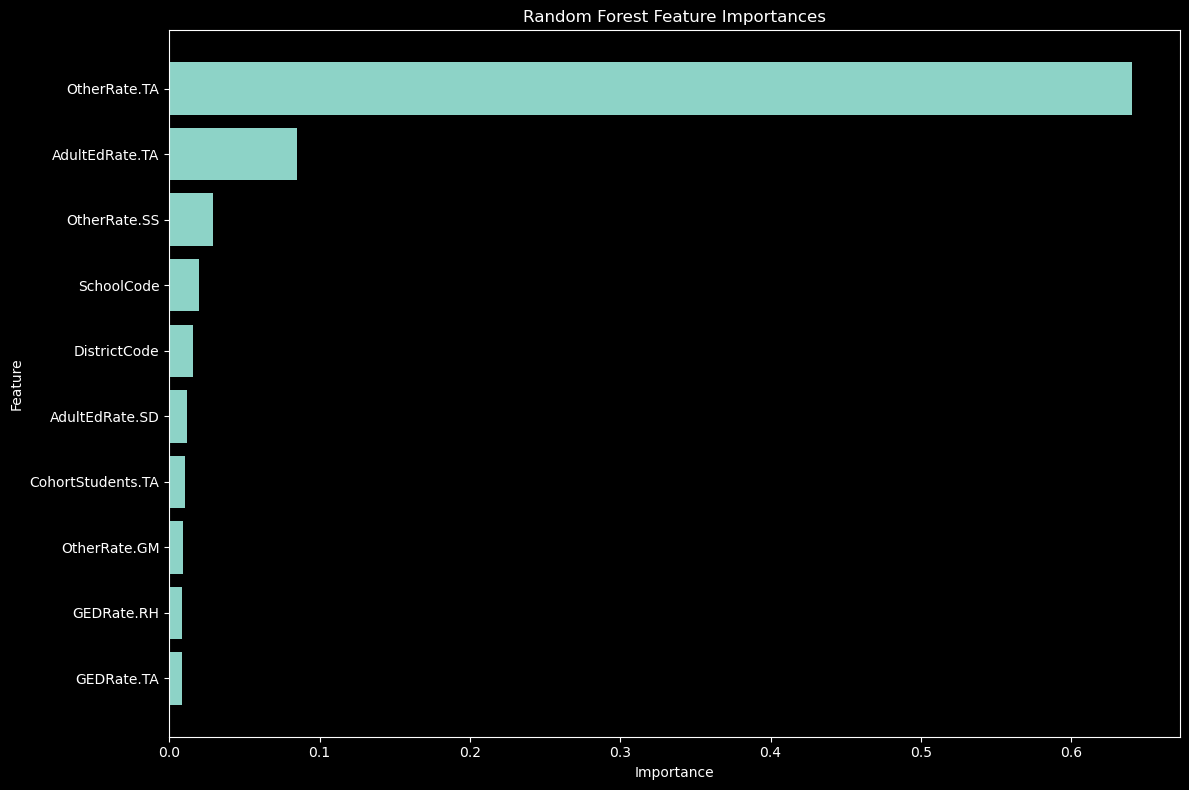

{'MSE': 81.19180310080453, 'RMSE': 9.01064942725021, 'R²': 0.7829924151132382}


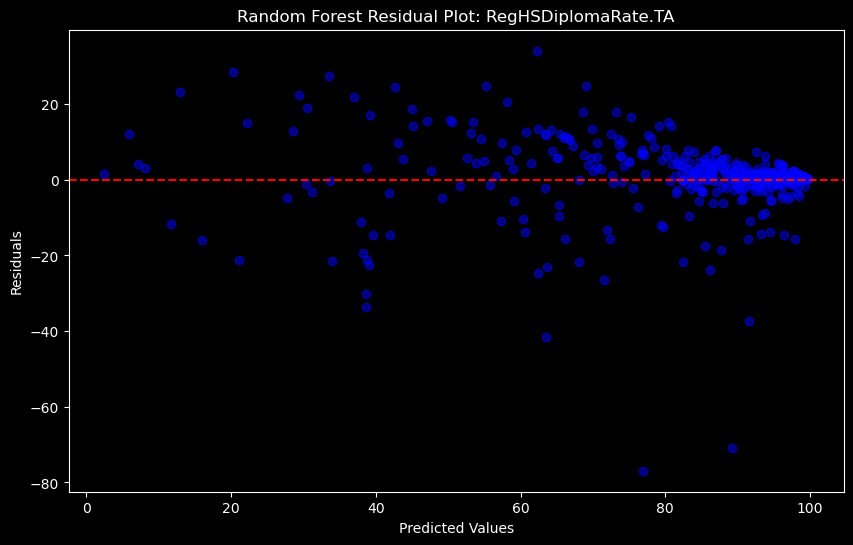

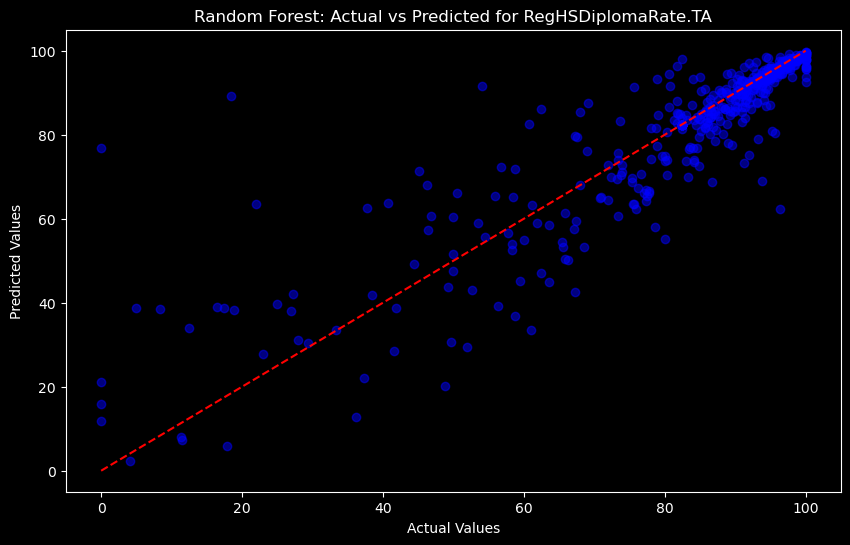

In [7]:
import modeling.utils.randomforest as rf_utils

df_2021_22_clean = df_2021_22.copy()
df_2021_22_clean = df_2021_22_clean.select_dtypes(include=[np.number])  # Keep only numeric columns
df_2021_22_clean = df_2021_22_clean.fillna(df_2021_22_clean.mean())  # Impute with mean

# Filter columns_to_drop to include only columns that exist in merged_clean
columns_to_drop_filtered = [col for col in columns_to_drop if col in df_2021_22_clean.columns]

rf_grad = rf_utils.train_random_forest_model(df_2021_22_clean, "RegHSDiplomaRate.TA", columns_to_drop_filtered)
print(rf_grad["metrics"])
rf_utils.plot_rf_residuals(rf_grad["y_test"], rf_grad["y_pred"], "RegHSDiplomaRate.TA")
rf_utils.plot_rf_actual_predicted(rf_grad["y_test"], rf_grad["y_pred"], "RegHSDiplomaRate.TA")

Predict CSU/UC Readiness


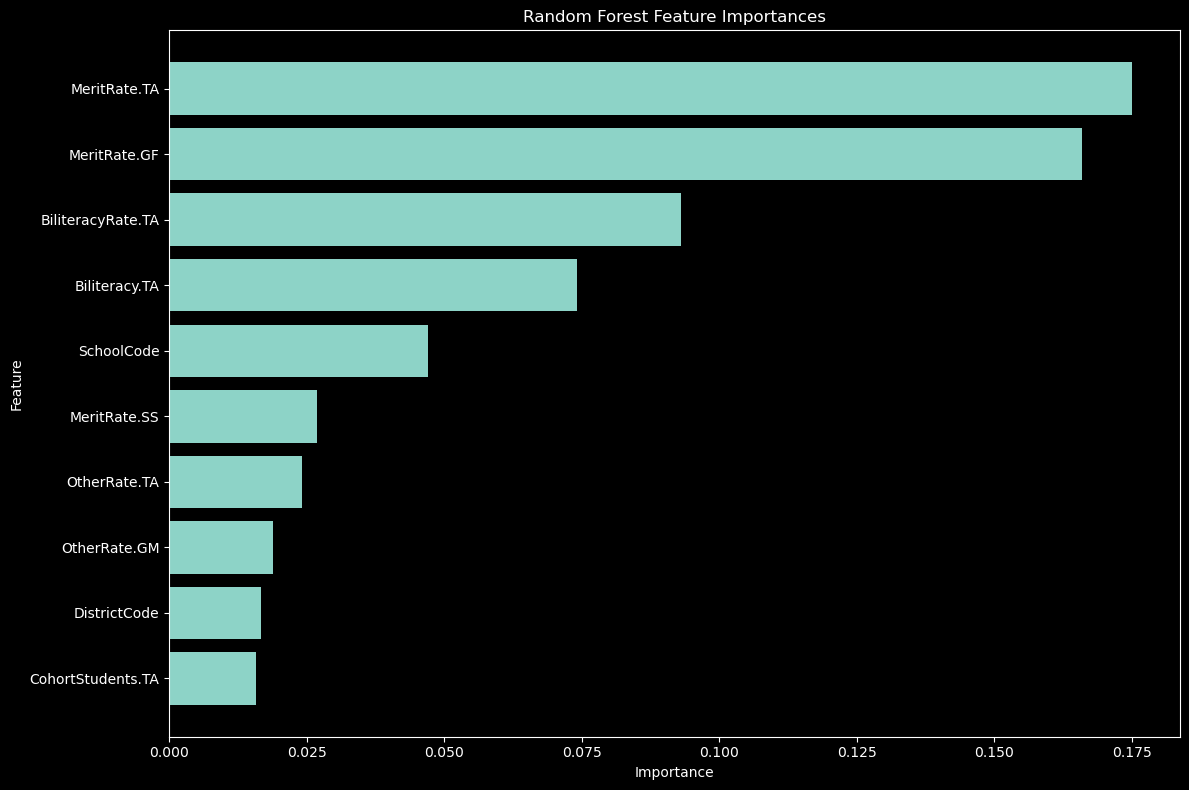

{'MSE': 246.98647014497217, 'RMSE': 15.715803197577022, 'R²': 0.7018786345549997}


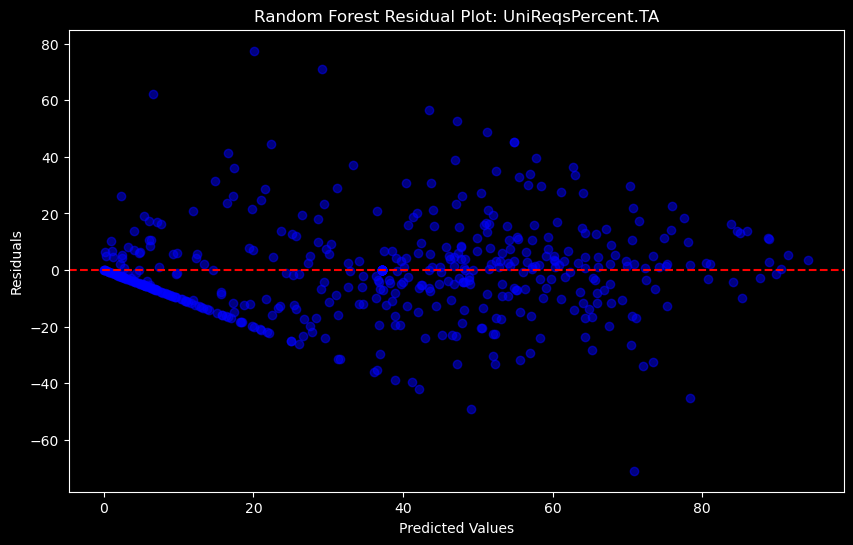

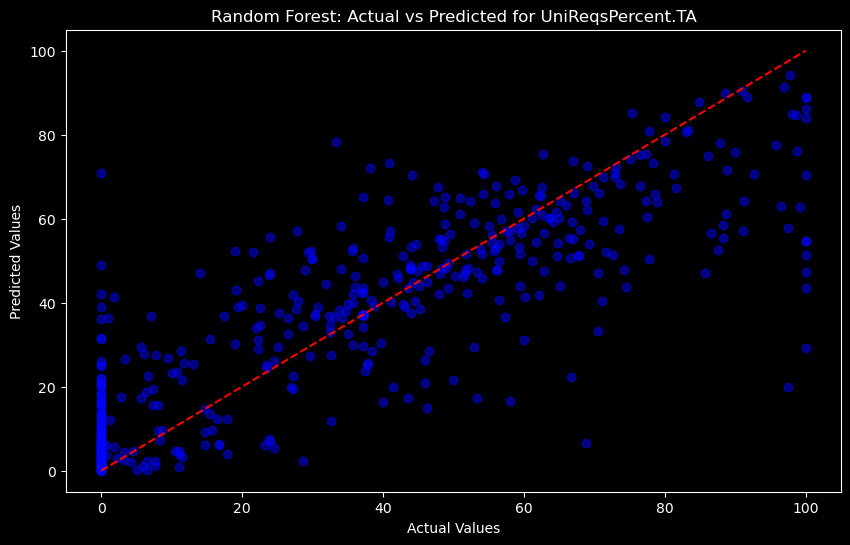

In [8]:
rf_uni = rf_utils.train_random_forest_model(df_2021_22_clean, "UniReqsPercent.TA", columns_to_drop_filtered)
print(rf_uni["metrics"])
rf_utils.plot_rf_residuals(rf_uni["y_test"], rf_uni["y_pred"], "UniReqsPercent.TA")
rf_utils.plot_rf_actual_predicted(rf_uni["y_test"], rf_uni["y_pred"], "UniReqsPercent.TA")

Predict Dropout Rate

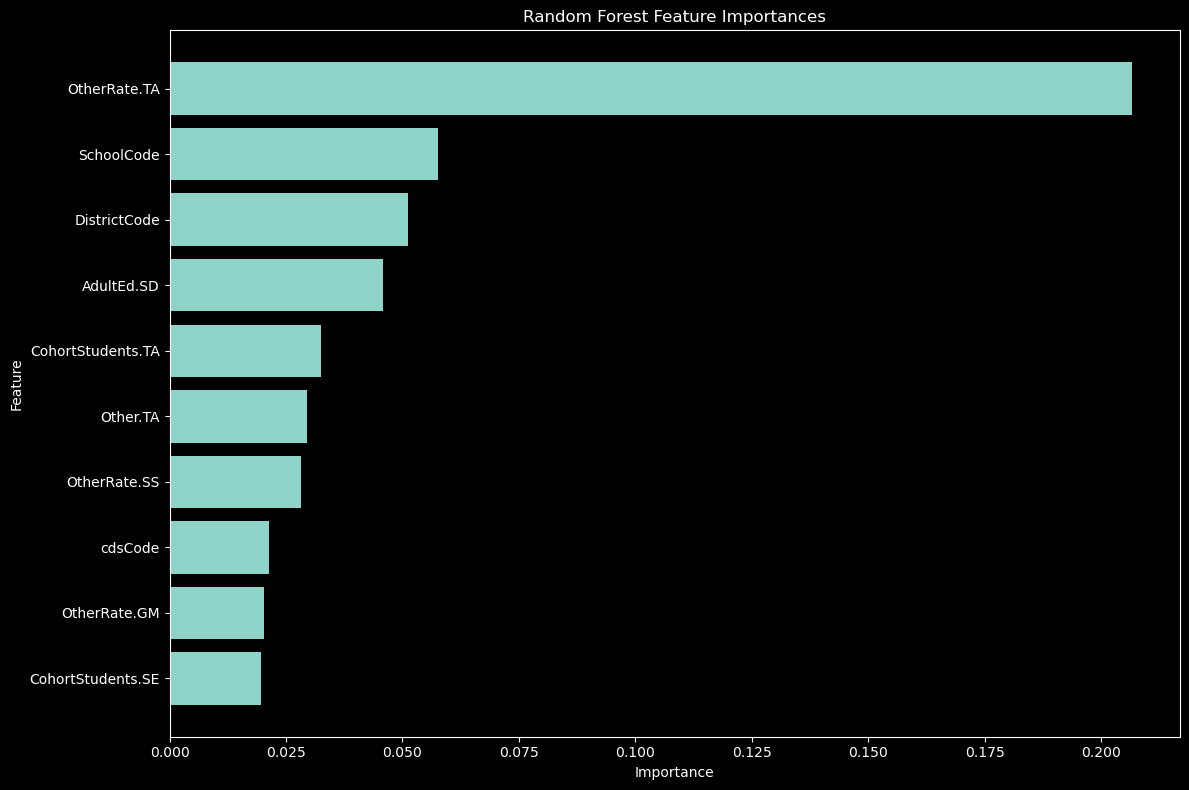

{'MSE': 68.6396283911717, 'RMSE': 8.284903644048716, 'R²': 0.26931785856007917}


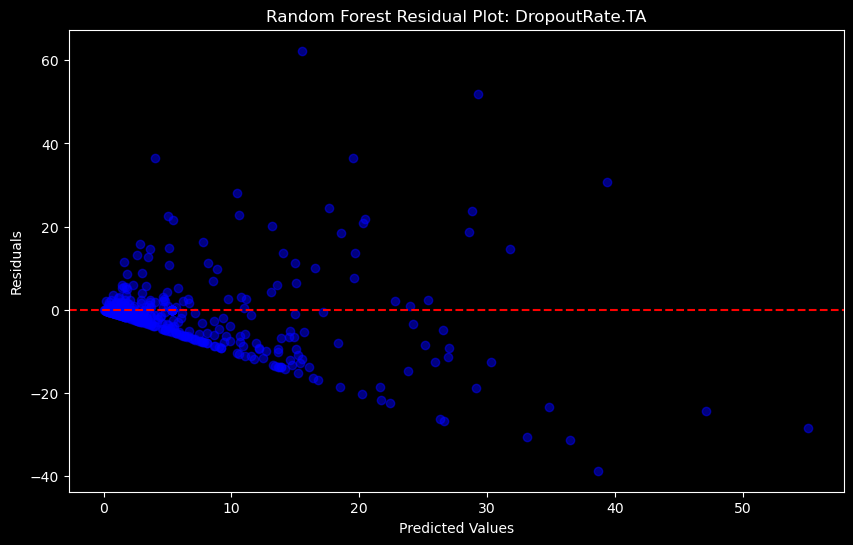

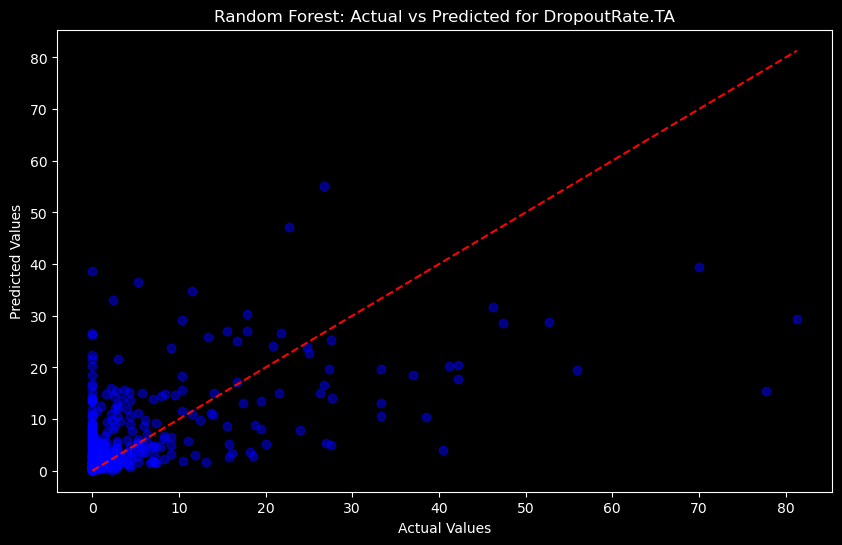

In [9]:
rf_dropout = rf_utils.train_random_forest_model(df_2021_22_clean, "DropoutRate.TA", columns_to_drop_filtered)
print(rf_dropout["metrics"])
rf_utils.plot_rf_residuals(rf_dropout["y_test"], rf_dropout["y_pred"], "DropoutRate.TA")
rf_utils.plot_rf_actual_predicted(rf_dropout["y_test"], rf_dropout["y_pred"], "DropoutRate.TA")